# Import data and libraries

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, matthews_corrcoef
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


tree_data = pd.read_csv('../../data/covtype.data', header=None)
tree_cols = ['Elevation', 'Aspect', 'Slope', 'Horizontal_To_Hydrology',
             'Vertical_To_Hydrology', 'Horizontal_To_Roadways',
             'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
             'Horizontal_To_Fire'] + \
            [f'Wilderness_Area_{i}' for i in range(4)] + \
            [f'Soil_Type_{i}' for i in range(40)] + \
            ['Cover_Type']

# print(tree_data.describe())
tree_data.columns = tree_cols
print("Nan values in dataset:", tree_data.isna().sum().sum())
print(tree_data.head())

Nan values in dataset: 0
   Elevation  Aspect  Slope  Horizontal_To_Hydrology  Vertical_To_Hydrology  \
0       2596      51      3                      258                      0   
1       2590      56      2                      212                     -6   
2       2804     139      9                      268                     65   
3       2785     155     18                      242                    118   
4       2595      45      2                      153                     -1   

   Horizontal_To_Roadways  Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0                     510            221             232            148   
1                     390            220             235            151   
2                    3180            234             238            135   
3                    3090            238             238            122   
4                     391            220             234            150   

   Horizontal_To_Fire  ...  Soil_Type_31  Soil_Ty

## Split training/testing data

In [25]:
x_tree = tree_data.drop('Cover_Type', axis=1)
y_tree = tree_data['Cover_Type']

x_train, x_test, y_train, y_test = train_test_split(x_tree, y_tree, test_size=0.2)


x_underSampled, y_underSampled = RandomUnderSampler(random_state=42, sampling_strategy='majority').fit_resample(x_train, y_train)

x_underSampled = x_underSampled.to_numpy()
y_underSampled = y_underSampled.to_numpy()

cw = compute_class_weight(class_weight="balanced", classes=np.unique(y_underSampled), y=y_underSampled)

data = tree_data.to_numpy()

## Class Distribution

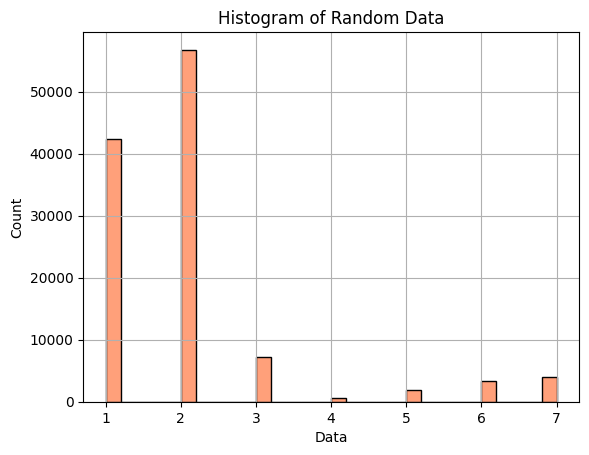

In [26]:
plt.hist(y_test, bins=30, color='lightsalmon', edgecolor='black')
plt.xlabel('Data')
plt.ylabel('Count')
plt.title('Histogram of Random Data')
plt.grid(True)
plt.show()

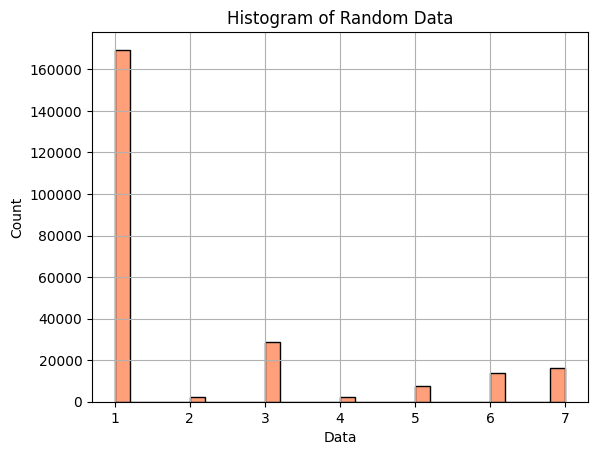

In [27]:
plt.hist(y_underSampled, bins=30, color='lightsalmon', edgecolor='black')
plt.xlabel('Data')
plt.ylabel('Count')
plt.title('Histogram of Random Data')
plt.grid(True)
plt.show()

## Scaling Dataset

In [28]:
scalar = StandardScaler()

scaled = scalar.fit_transform(x_underSampled[:, :10])

dataScaled = np.concatenate((scaled, x_underSampled[:,10:54]), axis=1)

x_Scaled_train, x_Scaled_test, y_Scaled_train, y_Scaled_test = train_test_split(dataScaled, y_underSampled.reshape(-1, 1), test_size=0.2)

## Mini Batch Gradient Descent with balanced class weights

In [29]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000, class_weight='balanced')

clf.fit(x_Scaled_train, y_Scaled_train.ravel())

print("Z Scaled Test Accuracy: ",clf.score(x_Scaled_test, y_Scaled_test))

Z Scaled Test Accuracy:  0.6715325431482637


## Mini Batch Gradient Descent

In [30]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000)

clf.fit(x_Scaled_train, y_Scaled_train.ravel())

print("Z Scaled Test Accuracy: ",clf.score(x_Scaled_test, y_Scaled_test))

Z Scaled Test Accuracy:  0.8739238927011853


## Stochastic Gradient Descent with balanced class weights

In [31]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(max_iter=1000, class_weight='balanced')

clf.fit(x_Scaled_train, y_Scaled_train.ravel())

print("Z Scaled Test Accuracy: ",clf.score(x_Scaled_test, y_Scaled_test))

Z Scaled Test Accuracy:  0.8088168018299022


## Stochastic Gradient Descent

In [32]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(max_iter=1000)

clf.fit(x_Scaled_train, y_Scaled_train.ravel())

print("Z Scaled Test Accuracy: ",clf.score(x_Scaled_test, y_Scaled_test))

Z Scaled Test Accuracy:  0.8510501143688917


## GridSearch with balanced class weights

In [ ]:

mcc_scorer = make_scorer(matthews_corrcoef, greater_is_better=True)
param_grid_LRB = {"penalty": ['l2', 'l1', 'elasticnet'], \
"C": [1.0, 0.75, 0.5, 0.25, 0], \
"solver": ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'], "max_iter": [1000, 2000]}

param_grid_SGDB = {"loss": ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error'], \
                  "penalty": ['l2', 'l1', 'elasticnet'], "max_iter": [1000, 2000]}

model_LRB = LogisticRegression(class_weight='balanced')
model_SGDB = SGDClassifier(class_weight='balanced')

grid_searchLRB = GridSearchCV(model_LRB, param_grid_LRB, cv=3, scoring=mcc_scorer, verbose=10)
grid_searchSGDB = GridSearchCV(model_SGDB, param_grid_SGDB, cv=3, scoring=mcc_scorer, verbose=10)

grid_searchLRB.fit(x_Scaled_train, y_Scaled_train.ravel())
grid_searchSGDB.fit(x_Scaled_train, y_Scaled_train.ravel())

print(grid_searchLRB.best_params_, grid_searchLRB.best_score_)
print(grid_searchSGDB.best_params_, grid_searchSGDB.best_score_)

Fitting 3 folds for each of 150 candidates, totalling 450 fits
[CV 1/3; 1/150] START C=1.0, max_iter=1000, penalty=l2, solver=lbfgs............
[CV 1/3; 1/150] END C=1.0, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.522 total time=   6.0s
[CV 2/3; 1/150] START C=1.0, max_iter=1000, penalty=l2, solver=lbfgs............
[CV 2/3; 1/150] END C=1.0, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.520 total time=   8.2s
[CV 3/3; 1/150] START C=1.0, max_iter=1000, penalty=l2, solver=lbfgs............
[CV 3/3; 1/150] END C=1.0, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.527 total time=   8.6s
[CV 1/3; 2/150] START C=1.0, max_iter=1000, penalty=l2, solver=newton-cg........
[CV 1/3; 2/150] END C=1.0, max_iter=1000, penalty=l2, solver=newton-cg;, score=0.522 total time=   5.3s
[CV 2/3; 2/150] START C=1.0, max_iter=1000, penalty=l2, solver=newton-cg........
[CV 2/3; 2/150] END C=1.0, max_iter=1000, penalty=l2, solver=newton-cg;, score=0.520 total time=   4.9s
[CV 3/3; 2/150] START C=

/home/seb/myenv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3; 4/150] END C=1.0, max_iter=1000, penalty=l2, solver=sag;, score=0.523 total time= 1.5min
[CV 2/3; 4/150] START C=1.0, max_iter=1000, penalty=l2, solver=sag..............


/home/seb/myenv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3; 4/150] END C=1.0, max_iter=1000, penalty=l2, solver=sag;, score=0.432 total time= 1.4min
[CV 3/3; 4/150] START C=1.0, max_iter=1000, penalty=l2, solver=sag..............


/home/seb/myenv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3; 4/150] END C=1.0, max_iter=1000, penalty=l2, solver=sag;, score=0.489 total time= 1.4min
[CV 1/3; 5/150] START C=1.0, max_iter=1000, penalty=l2, solver=saga.............


/home/seb/myenv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3; 5/150] END C=1.0, max_iter=1000, penalty=l2, solver=saga;, score=0.522 total time= 1.7min
[CV 2/3; 5/150] START C=1.0, max_iter=1000, penalty=l2, solver=saga.............


/home/seb/myenv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3; 5/150] END C=1.0, max_iter=1000, penalty=l2, solver=saga;, score=0.520 total time= 1.8min
[CV 3/3; 5/150] START C=1.0, max_iter=1000, penalty=l2, solver=saga.............


/home/seb/myenv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3; 5/150] END C=1.0, max_iter=1000, penalty=l2, solver=saga;, score=0.527 total time= 1.8min
[CV 1/3; 6/150] START C=1.0, max_iter=1000, penalty=l1, solver=lbfgs............
[CV 1/3; 6/150] END C=1.0, max_iter=1000, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3; 6/150] START C=1.0, max_iter=1000, penalty=l1, solver=lbfgs............
[CV 2/3; 6/150] END C=1.0, max_iter=1000, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3; 6/150] START C=1.0, max_iter=1000, penalty=l1, solver=lbfgs............
[CV 3/3; 6/150] END C=1.0, max_iter=1000, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/3; 7/150] START C=1.0, max_iter=1000, penalty=l1, solver=newton-cg........
[CV 1/3; 7/150] END C=1.0, max_iter=1000, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/3; 7/150] START C=1.0, max_iter=1000, penalty=l1, solver=newton-cg........
[CV 2/3; 7/150] END C=1.0, max_iter=1000, penalty=l1, solver=newton-cg;, score=nan total time=   0.0

/home/seb/myenv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3; 10/150] END C=1.0, max_iter=1000, penalty=l1, solver=saga;, score=0.510 total time= 2.4min
[CV 2/3; 10/150] START C=1.0, max_iter=1000, penalty=l1, solver=saga............


/home/seb/myenv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3; 10/150] END C=1.0, max_iter=1000, penalty=l1, solver=saga;, score=0.522 total time= 2.4min
[CV 3/3; 10/150] START C=1.0, max_iter=1000, penalty=l1, solver=saga............


/home/seb/myenv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3; 10/150] END C=1.0, max_iter=1000, penalty=l1, solver=saga;, score=0.528 total time= 2.4min
[CV 1/3; 11/150] START C=1.0, max_iter=1000, penalty=elasticnet, solver=lbfgs...
[CV 1/3; 11/150] END C=1.0, max_iter=1000, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3; 11/150] START C=1.0, max_iter=1000, penalty=elasticnet, solver=lbfgs...
[CV 2/3; 11/150] END C=1.0, max_iter=1000, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3; 11/150] START C=1.0, max_iter=1000, penalty=elasticnet, solver=lbfgs...
[CV 3/3; 11/150] END C=1.0, max_iter=1000, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/3; 12/150] START C=1.0, max_iter=1000, penalty=elasticnet, solver=newton-cg
[CV 1/3; 12/150] END C=1.0, max_iter=1000, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/3; 12/150] START C=1.0, max_iter=1000, penalty=elasticnet, solver=newton-cg
[CV 2/3; 12/150] END C=1.0, max_iter=1000, penalty=elasticnet

/home/seb/myenv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3; 19/150] END C=1.0, max_iter=2000, penalty=l2, solver=sag;, score=0.438 total time= 3.0min
[CV 2/3; 19/150] START C=1.0, max_iter=2000, penalty=l2, solver=sag.............


/home/seb/myenv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3; 19/150] END C=1.0, max_iter=2000, penalty=l2, solver=sag;, score=0.499 total time= 2.9min
[CV 3/3; 19/150] START C=1.0, max_iter=2000, penalty=l2, solver=sag.............


/home/seb/myenv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3; 19/150] END C=1.0, max_iter=2000, penalty=l2, solver=sag;, score=0.428 total time= 2.9min
[CV 1/3; 20/150] START C=1.0, max_iter=2000, penalty=l2, solver=saga............


/home/seb/myenv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3; 20/150] END C=1.0, max_iter=2000, penalty=l2, solver=saga;, score=0.527 total time= 3.5min
[CV 2/3; 20/150] START C=1.0, max_iter=2000, penalty=l2, solver=saga............


/home/seb/myenv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3; 20/150] END C=1.0, max_iter=2000, penalty=l2, solver=saga;, score=0.523 total time= 3.5min
[CV 3/3; 20/150] START C=1.0, max_iter=2000, penalty=l2, solver=saga............


/home/seb/myenv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3; 20/150] END C=1.0, max_iter=2000, penalty=l2, solver=saga;, score=0.524 total time= 3.5min
[CV 1/3; 21/150] START C=1.0, max_iter=2000, penalty=l1, solver=lbfgs...........
[CV 1/3; 21/150] END C=1.0, max_iter=2000, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3; 21/150] START C=1.0, max_iter=2000, penalty=l1, solver=lbfgs...........
[CV 2/3; 21/150] END C=1.0, max_iter=2000, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3; 21/150] START C=1.0, max_iter=2000, penalty=l1, solver=lbfgs...........
[CV 3/3; 21/150] END C=1.0, max_iter=2000, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/3; 22/150] START C=1.0, max_iter=2000, penalty=l1, solver=newton-cg.......
[CV 1/3; 22/150] END C=1.0, max_iter=2000, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/3; 22/150] START C=1.0, max_iter=2000, penalty=l1, solver=newton-cg.......
[CV 2/3; 22/150] END C=1.0, max_iter=2000, penalty=l1, solver=newton-cg;, score=nan total time=

/home/seb/myenv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3; 25/150] END C=1.0, max_iter=2000, penalty=l1, solver=saga;, score=0.521 total time= 4.3min
[CV 2/3; 25/150] START C=1.0, max_iter=2000, penalty=l1, solver=saga............


/home/seb/myenv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3; 25/150] END C=1.0, max_iter=2000, penalty=l1, solver=saga;, score=0.515 total time= 4.1min
[CV 3/3; 25/150] START C=1.0, max_iter=2000, penalty=l1, solver=saga............


/home/seb/myenv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3; 25/150] END C=1.0, max_iter=2000, penalty=l1, solver=saga;, score=0.518 total time= 4.2min
[CV 1/3; 26/150] START C=1.0, max_iter=2000, penalty=elasticnet, solver=lbfgs...
[CV 1/3; 26/150] END C=1.0, max_iter=2000, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3; 26/150] START C=1.0, max_iter=2000, penalty=elasticnet, solver=lbfgs...
[CV 2/3; 26/150] END C=1.0, max_iter=2000, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3; 26/150] START C=1.0, max_iter=2000, penalty=elasticnet, solver=lbfgs...
[CV 3/3; 26/150] END C=1.0, max_iter=2000, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/3; 27/150] START C=1.0, max_iter=2000, penalty=elasticnet, solver=newton-cg
[CV 1/3; 27/150] END C=1.0, max_iter=2000, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/3; 27/150] START C=1.0, max_iter=2000, penalty=elasticnet, solver=newton-cg
[CV 2/3; 27/150] END C=1.0, max_iter=2000, penalty=elasticnet

/home/seb/myenv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3; 34/150] END C=0.75, max_iter=1000, penalty=l2, solver=sag;, score=0.491 total time= 1.2min
[CV 2/3; 34/150] START C=0.75, max_iter=1000, penalty=l2, solver=sag............


/home/seb/myenv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3; 34/150] END C=0.75, max_iter=1000, penalty=l2, solver=sag;, score=0.559 total time= 1.2min
[CV 3/3; 34/150] START C=0.75, max_iter=1000, penalty=l2, solver=sag............


/home/seb/myenv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3; 34/150] END C=0.75, max_iter=1000, penalty=l2, solver=sag;, score=0.563 total time= 1.2min
[CV 1/3; 35/150] START C=0.75, max_iter=1000, penalty=l2, solver=saga...........


## GridSearch without class weights

In [ ]:

mcc_scorer = make_scorer(matthews_corrcoef, greater_is_better=True)
param_grid_LR = {"penalty": ['l2', 'l1', 'elasticnet'], \
"C": [1.0, 0.75, 0.5, 0.25, 0], \
"solver": ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'], "max_iter": [1000, 2000]}

param_grid_SGD = {"loss": ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error'], \
                  "penalty": ['l2', 'l1', 'elasticnet'], "max_iter": [1000, 2000]}

model_LR = LogisticRegression()
model_SGD = SGDClassifier()

grid_searchLR = GridSearchCV(model_LR, param_grid_LR, cv=3, scoring=mcc_scorer, verbose=10)
grid_searchSGD = GridSearchCV(model_SGD, param_grid_SGD, cv=3, scoring=mcc_scorer, verbose=10)

grid_searchLR.fit(x_Scaled_train, y_Scaled_train.ravel())
grid_searchSGD.fit(x_Scaled_train, y_Scaled_train.ravel())

print(grid_searchLR.best_params_, grid_searchLR.best_score_)
print(grid_searchSGD.best_params_, grid_searchSGD.best_score_)